The data for the project is taken from kaggle https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification.

In the working directory I created a folder data with three empty directories train, val and test.

Run the python notebook sequentially.

[forthebadge](https://forthebadge.com)

In [6]:
import os
import glob
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#!pip install split-folders

In [2]:
import splitfolders

In [7]:
os.getcwd()
os.chdir('C:\\Users\\Lenovo\\Desktop\\Omdena')

In [8]:
input_folder = 'Garbage classification/'
splitfolders.ratio(input_folder, output = 'data', seed = 42, ratio = (.7,.2,.1), group_prefix = None)

Copying files: 2527 files [01:56, 21.70 files/s]


In [9]:
train_path = 'C:/Users/Lenovo/Desktop/Omdena/data/train'
valid_path = 'C:/Users/Lenovo/Desktop/Omdena/data/val'

**Checking the number of images in the training set and validation set**

In [6]:
len(os.listdir(train_path + '/cardboard'))

282

In [7]:
len(os.listdir(train_path + '/glass'))

350

In [8]:
len(os.listdir(train_path + '/paper'))

415

In [9]:
len(os.listdir(train_path + '/plastic'))

337

In [10]:
len(os.listdir(train_path + '/trash'))

95

In [11]:
len(os.listdir(train_path + '/metal'))

287

In [12]:
len(os.listdir(valid_path + '/metal'))

82

**Plotting the images**

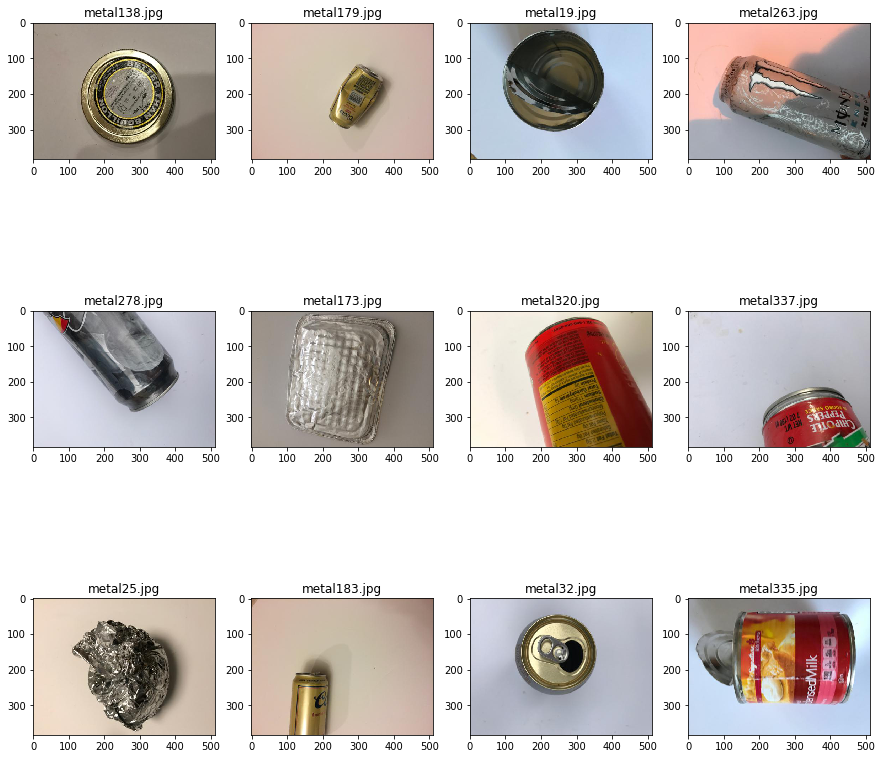

In [13]:
## Displaying the first 12 images of fresh leaves from the training set

fig = plt.figure(figsize = (15,15))
columns = 4
rows = 3
i = 1

for img_name in os.listdir(train_path+'/metal'):
    img = train_path + '/metal' +'/'+ img_name
    img = plt.imread(img)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img, interpolation = 'nearest')
    ax.title.set_text(img_name)
    i = i+1
    if i == columns*rows+1:
        break
    
plt.show()

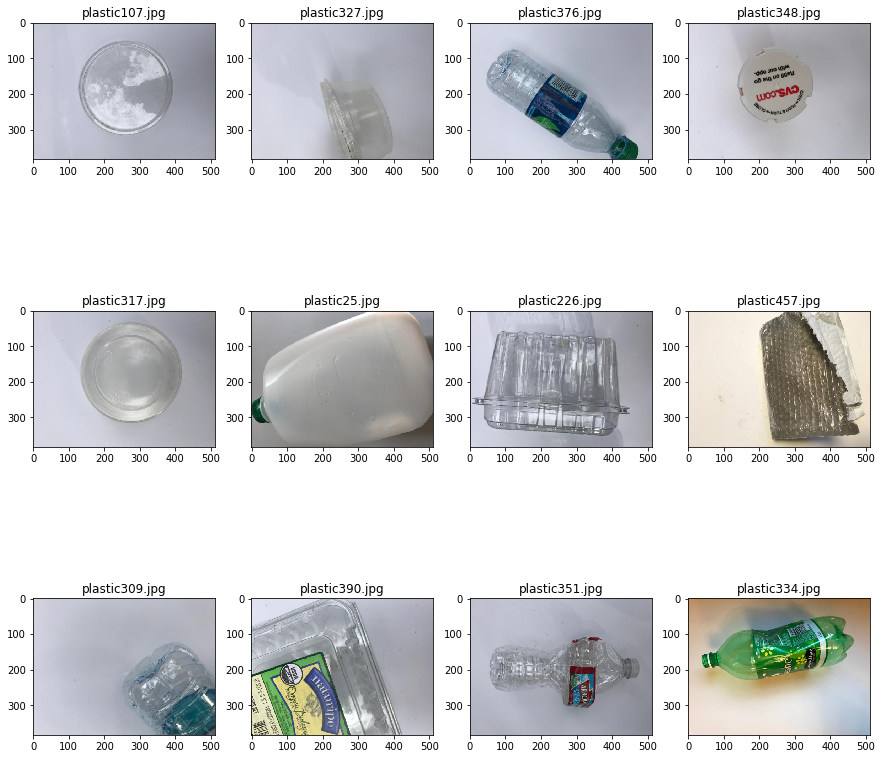

In [14]:
## Displaying the first 12 images of diseased leaves from the training set

fig = plt.figure(figsize = (15,15))
columns = 4
rows = 3
i = 1

for img_name in os.listdir(train_path+'/plastic'):
    img = train_path + '/plastic/' + img_name
    img = plt.imread(img)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img, interpolation = 'nearest')
    ax.title.set_text(img_name)
    i = i+1
    if i == columns*rows+1:
        break
    
plt.show()

**Checking the dimension for each image**

In [15]:
images = os.listdir(train_path + '/metal/')

In [16]:
width, height = [], []

for image_name in images:
    img = plt.imread(train_path+ '/metal/' + image_name)
    w, h, c = img.shape
    width.append(w)
    height.append(h)

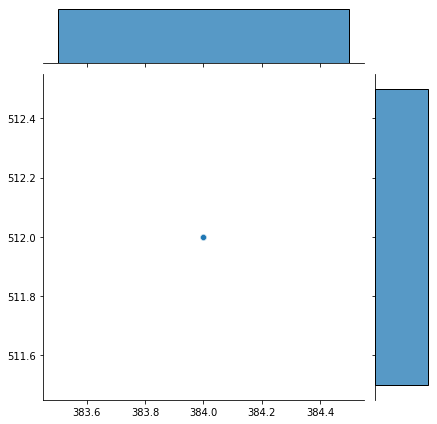

In [17]:
sns.jointplot( x = width, y = height, kind = 'scatter')
plt.show()

Most of the images have dimension either (384*512)

In [18]:
import numpy as np

print('Mean width: {}'.format(np.mean(width)))

print('Mean Height: {}'.format(np.mean(height)))

Mean width: 384.0
Mean Height: 512.0


We will keep the size of the image as (384*512 x 3)

In [19]:
IMAGE_SIZE = (384, 512, 3)

**Checking images are scaled or not**

In [20]:
img_name = os.listdir(train_path + '/metal')[0]
img = plt.imread(train_path+'/metal/'+img_name)

print('Maximum pizel value: {}'.format(np.max(img)))

print('Minimum pizel value: {}'.format(np.min(img)))

## Image is not scaled

Maximum pizel value: 255
Minimum pizel value: 0


**Creating Image Data Generator for Training and Validation set**

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
train_batches = train_datagen.flow_from_directory(directory = train_path,
                                                 target_size = (384, 384),
                                                 classes = ['cardboard', 'metal','paper','plastic','trash','glass'],
                                                 batch_size = 10,
                                                 shuffle = True, class_mode = 'categorical')

valid_batches = valid_datagen.flow_from_directory(directory = valid_path,
                                                 target_size = (384, 384),
                                                 classes = ['cardboard', 'metal','paper','plastic','trash','glass'],
                                                 batch_size = 10,
                                                 shuffle = False, class_mode = 'categorical')

Found 1766 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [23]:
train_batches.class_indices

{'cardboard': 0, 'glass': 5, 'metal': 1, 'paper': 2, 'plastic': 3, 'trash': 4}

**Let us see how the traing batch looks like**

In [24]:
imgs, labels = next(train_batches) ## getting first 10 images (1st batch)

## Everytime this line of code is run next 10 images are selected

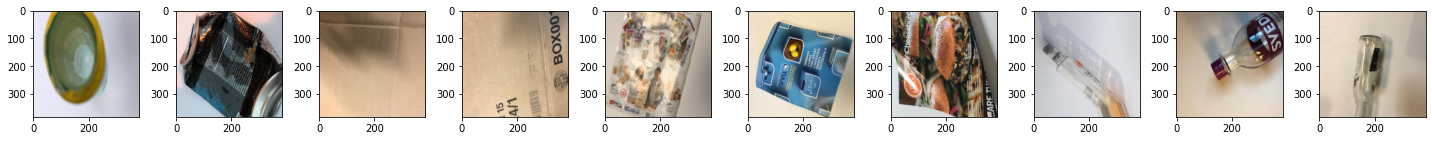

In [25]:
fig, axes = plt.subplots(1, 10, figsize = (20,20))
axes = axes.flatten()
for img, ax in zip(imgs, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [26]:
labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [27]:
img = imgs[0]

print('Maximum pixel value: {}'.format(np.max(img)))

print('Minimum pixel value: {}'.format(np.min(img)))

Maximum pixel value: 1.0
Minimum pixel value: 0.0


Note how the image size and maximum and minimum pixel value are changed

Now the images are rescaled!!

**Building CNN model**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [29]:
model = Sequential()

model.add(Convolution2D(filters = 128, kernel_size =  (3,3), input_shape = (384, 384, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Convolution2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Convolution2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(Convolution2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 6 , activation = 'softmax'))

In [30]:
model.compile(optimizer = 'adam' ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 382, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 191, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 189, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 94, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 92, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        3

In [32]:
r = model.fit(train_batches,
                        steps_per_epoch = len(train_batches),
                        epochs = 20,
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        callbacks = EarlyStopping(monitor='val_loss', patience = 2))

Epoch 1/20
177/177 [==============================] - 1017s 6s/step - loss: 1.7394 - accuracy: 0.2271 - val_loss: 1.7099 - val_accuracy: 0.3022
Epoch 2/20
177/177 [==============================] - 68s 385ms/step - loss: 1.6008 - accuracy: 0.3194 - val_loss: 1.5566 - val_accuracy: 0.3877
Epoch 3/20
177/177 [==============================] - 69s 392ms/step - loss: 1.5591 - accuracy: 0.3579 - val_loss: 1.5558 - val_accuracy: 0.3698
Epoch 4/20
177/177 [==============================] - 68s 383ms/step - loss: 1.5223 - accuracy: 0.3686 - val_loss: 1.6595 - val_accuracy: 0.2922
Epoch 5/20
177/177 [==============================] - 69s 391ms/step - loss: 1.5091 - accuracy: 0.3635 - val_loss: 1.5441 - val_accuracy: 0.3419
Epoch 6/20
177/177 [==============================] - 68s 385ms/step - loss: 1.4804 - accuracy: 0.4105 - val_loss: 1.4788 - val_accuracy: 0.3837
Epoch 7/20
177/177 [==============================] - 69s 391ms/step - loss: 1.4355 - accuracy: 0.4417 - val_loss: 1.5606 - val_acc

In [33]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

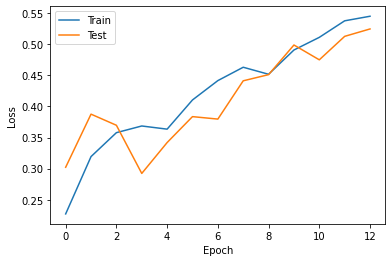

In [35]:
plt.plot(r.history['accuracy'], label = 'Train')
plt.plot(r.history['val_accuracy'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model.evaluate(train_batches)
#train_batches.classes

177/177 [==============================] - 69s 389ms/step - loss: 1.1004 - accuracy: 0.5798


[1.100445032119751, 0.5798414349555969]

In [37]:
model.evaluate(valid_batches)

51/51 [==============================] - 4s 75ms/step - loss: 1.3165 - accuracy: 0.5249


[1.3164846897125244, 0.5248509049415588]

In [38]:
train_pred = model.predict(train_batches)

In [39]:
train_classes_pred = np.argmax(train_pred, axis = 1)

In [40]:
train_classes_pred

array([5, 5, 3, ..., 4, 2, 0])

In [41]:
train_classes_actual = train_batches.classes

In [42]:
train_classes_actual

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [43]:
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_classes_actual, train_classes_pred)
print(cm)

[[ 31  34  78  43   2  94]
 [ 36  31  71  54   1  94]
 [ 60  52  97  67   7 132]
 [ 34  26 101  61   6 109]
 [ 20   7  22  20   1  25]
 [ 42  43  96  58   6 105]]


In [44]:
valid_classes = model.predict(valid_batches)
valid_classes_pred = np.argmax(valid_classes, axis = 1)
valid_classes_actual = valid_batches.classes
cm = confusion_matrix(valid_classes_actual, valid_classes_pred)
print(cm)

[[51  3 14  2  0 10]
 [ 1 23 14  3  3 38]
 [ 1 12 75 16  1 13]
 [ 1  4 17 50  2 22]
 [ 0  2  4  3  3 15]
 [ 1  4 18 15  0 62]]
